In [1]:
# 必要なパッケージを呼び出す
using NLsolve
using Plots
using Roots
using LaTeXStrings

In [2]:
# MATLABではグローバル変数を使って関数への変数受け渡しを行う
# Julia/Pythonではコンストラクタを用いる

# ギリシャ文字の使用は不可とする
struct Model{TI<:Integer, TF<:AbstractFloat}

    # カリブレーション
    alpha::TF 
    beta::TF           
    delta::TF 
    gamma::TF
    Abar::TF
    gbar::TF

    # 定常状態の値
    kss::TF
    css::TF
    Rss::TF    
    
    # 移行過程に関する変数
    T::TI

end

In [3]:
function shooting_tauc(m,x,k0,tauc)
    """
    ------------------------------------------------------
    === ためし打ち法において、消費と資本の流列を求める関数 ===
    ------------------------------------------------------
    <input>
    ・m: パラメータ等を含む構造体
    ・x: 消費の初期値(求根問題の為にベクトル表記している)
    ・k0: 資本の初期値
    ・tauc: 消費税の流列
    <output>
    ・k: 資本の流列
    ・c: 消費の流列
    ・R: 金利
    """
    
    c0 = x[1];
    k = zeros(m.T+1);
    c = zeros(m.T+1);
    R = zeros(m.T+1);

    k[1] = k0;
    c[1] = c0;
    R[1] = 1/m.beta

    for t in 1:T

        k[t+1] = max(m.Abar*(k[t]^m.alpha) + (1-m.delta)*k[t] - m.gbar - c[t], 1e-4); # k>0
        R[t+1] = ((1+tauc[t])/(1+tauc[t+1])) * (1-m.delta + m.alpha*m.Abar*k[t+1]^(m.alpha-1));
        RHS = m.beta*R[t+1]*(c[t]^m.gamma);
        c[t+1] = RHS^(1/m.gamma);

    end

    #r .= m.alpha .* m.Abar .* k.^(m.alpha-1);

    return k, c, R
end

shooting_tauc (generic function with 1 method)

In [4]:
# カリブレーション
alpha = 0.33; 
beta = 0.95;
delta = 0.2; 
gamma = 2.0;
Abar = 1.0;
gbar = 0.2;

# 定常状態の値
kss = (alpha*beta*Abar/(1-beta*(1-delta)))^(1/(1-alpha));
css = kss^alpha - delta*kss - gbar;
Rss = 1 - delta + alpha*Abar*kss^(alpha-1);

# 移行過程に関する変数
T = 100; 

# k の初期値
k0 = kss; 

#### 将来の消費増税の影響 (saddlepath_shooting_tauc.m に対応)

In [7]:
m = Model(alpha,beta,delta,gamma,Abar,gbar,kss,css,Rss,T);
tauc = zeros(m.T+1);
tauc[11:m.T+1] .= 0.2;

# プロット用に先に変数を定義しておく
k = 0.0;
c = 0.0;
#r = 0.0;
R = 0.0;

# bisection
cL = 0.001;
cH = 3.0;
diff = 1e+4;

while diff > 1e-15

    c0 = (cL+cH)/2;
    k,c,R = shooting_tauc(m,[c0],k0,tauc);
    err = k[m.T] - m.kss;
    
    println([c0 err])
    flush(stdout)

    if err > 0
        cL = copy(c0);
    else
        cH = copy(c0);
    end

    diff = abs(cH-cL);

end

[1.5005 -1.4898564934347787]
[0.7507499999999999 -1.4898564934347787]
[0.37587499999999996 8.024645949947123]
[0.5633124999999999 8.022098337586485]
[0.65703125 -1.4898564934347787]
[0.6101718749999999 8.019842556613659]
[0.6336015625 8.016247929691442]
[0.64531640625 8.007505202291272]
[0.6511738281249999 -1.4898564934347787]
[0.6482451171874999 7.992222632998656]
[0.6497094726562499 -1.4898564934347787]
[0.6489772949218748 7.967881440923513]
[0.6493433837890623 -1.4898564934347787]
[0.6491603393554686 7.938736775954789]
[0.6492518615722654 7.861942892778295]
[0.6492976226806639 -1.4898564934347787]
[0.6492747421264646 7.680770605480939]
[0.6492861824035643 -1.4898564934347787]
[0.6492804622650145 -1.4898564934347787]
[0.6492776021957396 7.523336819581951]
[0.649279032230377 7.168842095454403]
[0.6492797472476957 -1.4898564934347787]
[0.6492793897390363 6.692464414617675]
[0.649279568493366 -1.4898564934347787]
[0.6492794791162011 6.267278243636953]
[0.6492795238047835 5.6968228507578

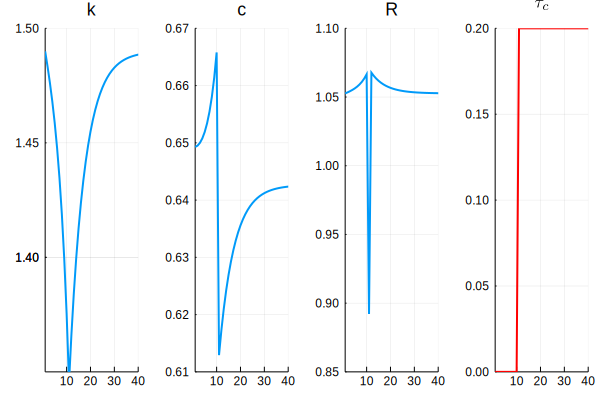

In [8]:
p1 = plot(k,title="k",ylims=(1.35,1.5),lw=2,legend=false);
p2 = plot(c,title="c",ylims=(0.61,0.67),lw=2,legend=false);
#p3 = plot(r.+1 .-m.delta,title="r",ylims=(1.05,1.07),lw=2,legend=false);
p3 = plot(R,title="R",ylims=(0.85,1.1),lw=2,legend=false);
p4 = plot(tauc,title=L"\tau_{c}",ylims=(0,0.2),c=:red,lw=2,legend=false);

plot(p1,p2,p3,p4,xlims=(1,40),layout=(1,4),titlefontsize=12)